In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import uuid
import os
import os.path
import utils
import utils.wavelet
import utils.data
import utils.data.augmentation
import numpy as np
import scipy as sp
import scipy.signal
import pandas as pd
import wfdb
import json
import tqdm
import matplotlib.pyplot as plt
from scipy.stats import norm
from utils.signal import StandardHeader

# Data loader to un-clutter code    
def load_data(filepath):
    dic = dict()
    with open(filepath) as f:
        text = list(f)
    for line in text:
        line = line.replace(' ','').replace('\n','').replace(',,','')
        if line[-1] == ',': line = line[:-1]
        head = line.split(',')[0]
        tail = line.split(',')[1:]
        if tail == ['']:
            tail = np.asarray([])
        else:
            tail = np.asarray(tail).astype(int)

        dic[head] = tail
    return dic


def trailonset(sig,on):
    on = on-sig[0]
    off = on-sig[0]+sig[-1]
    sig = sig+np.linspace(on,off,sig.size)
    
    return sig

# Load LUDB

In [3]:
dataset = {}
Pon = {}
Ppeak = {}
Poff = {}
QRSon = {}
QRSpeak = {}
QRSoff = {}
Ton = {}
Tpeak = {}
Toff = {}
group = {}

for i in tqdm.tqdm(range(200)):
    (signal, header) = wfdb.rdsamp(r'C:\Users\Emilio\Documents\DADES\DADES\Delineator\ludb\{}'.format(i+1))
    sortOrder = np.where(np.array([x.upper() for x in header['sig_name']])[:,None] == StandardHeader)[1]
    signal = signal[:,sortOrder]
    if header['fs'] != 500:
        print(header['fs'])
    signal = sp.signal.decimate(signal,2,axis=0)
    
    # 1st step: reduce noise
    signal = sp.signal.filtfilt(*sp.signal.butter(4,   0.5/250., 'high'),signal.T).T
    signal = sp.signal.filtfilt(*sp.signal.butter(4, 125.0/250.,  'low'),signal.T).T

    # 2nd step: retrieve onsets and offsets
    for j in range(len(StandardHeader)):
        lead = StandardHeader[j]
        name = str(i+1)+"_"+lead
        ann = wfdb.rdann(r'C:\Users\Emilio\Documents\DADES\DADES\Delineator\ludb\{}'.format(i+1),'atr_{}'.format(lead.lower()))
        dataset[name] = signal[:,j]
        
        locP = np.where(np.array(ann.symbol) == 'p')[0]
        if len(locP) != 0:
            if locP[0]-1 < 0:
                locP = locP[1:]
            if locP[-1]+1 == len(ann.sample):
                locP = locP[:-1]
        Pon[name] = ann.sample[locP-1]//2
        Ppeak[name] = ann.sample[locP]//2
        Poff[name] = ann.sample[locP+1]//2

        locQRS = np.where(np.array(ann.symbol) == 'N')[0]
        if len(locQRS) != 0:
            if locQRS[0]-1 < 0:
                locQRS = locQRS[1:]
            if locQRS[-1]+1 == len(ann.sample):
                locQRS = locQRS[:-1]
        QRSon[name] = ann.sample[locQRS-1]//2
        QRSpeak[name] = ann.sample[locQRS]//2
        QRSoff[name] = ann.sample[locQRS+1]//2

        locT = np.where(np.array(ann.symbol) == 't')[0]
        if len(locT) != 0:
            if locT[0]-1 < 0:
                locT = locT[1:]
            if locT[-1]+1 == len(ann.sample):
                locT = locT[:-1]
        Ton[name] = ann.sample[locT-1]//2
        Tpeak[name] = ann.sample[locT]//2
        Toff[name] = ann.sample[locT+1]//2
        
        # Store group
        group[name] = str(i+1)

dataset = pd.DataFrame(dataset)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:19<00:00, 10.18it/s]


In [4]:
Psignal = {}
PQsignal = {}
QRSsignal = {}
STsignal = {}
Tsignal = {}
TPsignal = {}

Pgroup = {}
PQgroup = {}
QRSgroup = {}
STgroup = {}
Tgroup = {}
TPgroup = {}

for k in tqdm.tqdm(dataset.keys()):
    # Buggy files
    if k in ['116_{}'.format(h) for h in StandardHeader]:
        continue
    pon = Pon.get(k,np.array([]))
    pof = Poff.get(k,np.array([]))
    qon = QRSon.get(k,np.array([]))
    qof = QRSoff.get(k,np.array([]))
    ton = Ton.get(k,np.array([]))
    tof = Toff.get(k,np.array([]))
    
    unordered_samples = np.concatenate([pon,pof,qon,qof,ton,tof,]).astype(float)
    unordered_symbols = np.concatenate([['Pon']*pon.size,['Poff']*pof.size,
                                        ['QRSon']*qon.size,['QRSoff']*qof.size,
                                        ['Ton']*ton.size,['Toff']*tof.size,])
    # Sort fiducials taking logical orders if same sample of occurrence
    # There is (I'm definitely sure) a better way to do it
    samples = []
    symbols = []
    for i in range(unordered_samples.size):
        minimum = np.where(unordered_samples == min(unordered_samples))[0]
        if minimum.size == 1:
            minimum = minimum[0]
            samples.append(int(unordered_samples[minimum]))
            symbols.append(unordered_symbols[minimum])
            unordered_samples[minimum] = np.inf
        elif minimum.size == 2:
            if symbols[-1] == 'Pon':
                if unordered_symbols[minimum[0]] == 'Poff':
                    samples.append(int(unordered_samples[minimum[0]]))
                    symbols.append(unordered_symbols[minimum[0]])
                    unordered_samples[minimum[0]] = np.inf
                elif unordered_symbols[minimum[1]] == 'Poff':
                    samples.append(int(unordered_samples[minimum[1]]))
                    symbols.append(unordered_symbols[minimum[1]])
                    unordered_samples[minimum[1]] = np.inf
            elif symbols[-1] == 'QRSon':
                if unordered_symbols[minimum[0]] == 'QRSoff':
                    samples.append(int(unordered_samples[minimum[0]]))
                    symbols.append(unordered_symbols[minimum[0]])
                    unordered_samples[minimum[0]] = np.inf
                elif unordered_symbols[minimum[1]] == 'QRSoff':
                    samples.append(int(unordered_samples[minimum[1]]))
                    symbols.append(unordered_symbols[minimum[1]])
                    unordered_samples[minimum[1]] = np.inf
            elif symbols[-1] == 'Ton':
                if unordered_symbols[minimum[0]] == 'Toff':
                    samples.append(int(unordered_samples[minimum[0]]))
                    symbols.append(unordered_symbols[minimum[0]])
                    unordered_samples[minimum[0]] = np.inf
                elif unordered_symbols[minimum[1]] == 'Toff':
                    samples.append(int(unordered_samples[minimum[1]]))
                    symbols.append(unordered_symbols[minimum[1]])
                    unordered_samples[minimum[1]] = np.inf
            else:
                raise ValueError("Should not happen at all")
        else:
            raise ValueError("Definitely should not happen. Check file {}".format(k))
    samples = np.array(samples)
    symbols = np.array(symbols)
    
    # Extract segments
    for i in range(samples.size-1):
        if samples[i] == samples[i+1]:
            continue
        if symbols[i] == 'Pon':
            if symbols[i+1] == 'Poff':
                Psignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                Pgroup[k + '_' + str(i)] = (k,group[k])
            else:
                print("Check file {}. P onset not followed by offset".format(k))
        elif symbols[i] == 'QRSon':
            if symbols[i+1] == 'QRSoff':
                QRSsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                QRSgroup[k + '_' + str(i)] = (k,group[k])
            else:
                print("Check file {}. QRS onset not followed by offset".format(k))
        elif symbols[i] == 'Ton':
            if symbols[i+1] == 'Toff':
                Tsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                Tgroup[k + '_' + str(i)] = (k,group[k])
            else:
                print("Check file {}. T onset not followed by offset".format(k))
        elif symbols[i] == 'Poff':
            if symbols[i+1] == 'Pon':
                TPsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                TPgroup[k + '_' + str(i)] = (k,group[k])
            elif symbols[i+1] == 'QRSon':
                PQsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                PQgroup[k + '_' + str(i)] = (k,group[k])
            elif symbols[i+1] == 'Ton':
                TPsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                TPgroup[k + '_' + str(i)] = (k,group[k])
            elif symbols[i+1] in ['Poff','QRSoff','Toff']:
                print("Check file {}. P offset not followed by onset".format(k))
        elif symbols[i] == 'QRSoff':
            if symbols[i+1] == 'Pon':
                TPsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                TPgroup[k + '_' + str(i)] = (k,group[k])
            elif symbols[i+1] == 'QRSon':
                TPsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                TPgroup[k + '_' + str(i)] = (k,group[k])
            elif symbols[i+1] == 'Ton':
                STsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                STgroup[k + '_' + str(i)] = (k,group[k])
            elif symbols[i+1] in ['Poff','QRSoff','Toff']:
                print("Check file {}. P offset not followed by onset".format(k))
        elif symbols[i] == 'Toff':
            if symbols[i+1] == 'Pon':
                TPsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                TPgroup[k + '_' + str(i)] = (k,group[k])
            elif symbols[i+1] == 'QRSon':
                TPsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                TPgroup[k + '_' + str(i)] = (k,group[k])
            elif symbols[i+1] == 'Ton':
                TPsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                TPgroup[k + '_' + str(i)] = (k,group[k])
            elif symbols[i+1] in ['Poff','QRSoff','Toff']:
                print("Check file {}. P offset not followed by onset".format(k))
        else:
            raise ValueError("This should definitely not happen")


100%|█████████████████████████████████████████████████████████████████████████████| 2400/2400 [00:20<00:00, 115.34it/s]


In [5]:
print(len(Pgroup))
print(len(PQgroup))
print(len(QRSgroup))
print(len(STgroup))
print(len(Tgroup))
print(len(TPgroup))

16641
16625
21789
19477
19497
19334


# Load QT db

In [6]:
path = r'C:\Users\Emilio\Documents\DADES\DADES\PhysioNet\QTDB\2020'

#### LOAD DATASETS ####
dataset             = pd.read_csv(os.path.join(path, 'Dataset.csv'), index_col=0)
dataset             = dataset.sort_index(axis=1)
labels              = np.asarray(list(dataset)) # In case no data augmentation is applied
description         = dataset.describe()
group               = {k: '_'.join(k.split('_')[:-1]) for k in dataset}

# Zero-center data
for key in description:
    dataset[key]    = (dataset[key] - description[key]['mean'])/description[key]['std']
    
Pon = load_data(os.path.join(path, 'PonNew.csv'))
Poff = load_data(os.path.join(path, 'PoffNew.csv'))
QRSon = load_data(os.path.join(path, 'QRSonNew.csv'))
QRSoff = load_data(os.path.join(path, 'QRSoffNew.csv'))
Ton = load_data(os.path.join(path, 'TonNew.csv'))
Toff = load_data(os.path.join(path, 'ToffNew.csv'))

In [7]:
for k in tqdm.tqdm(dataset.keys()):
    # Buggy files
    if k in ['sel232_0', 'sel232_1']:
        continue
    pon = Pon.get(k,np.array([]))
    pof = Poff.get(k,np.array([]))
    qon = QRSon.get(k,np.array([]))
    qof = QRSoff.get(k,np.array([]))
    ton = Ton.get(k,np.array([]))
    tof = Toff.get(k,np.array([]))
    
    unordered_samples = np.concatenate([pon,pof,qon,qof,ton,tof,]).astype(float)
    unordered_symbols = np.concatenate([['Pon']*pon.size,['Poff']*pof.size,
                                        ['QRSon']*qon.size,['QRSoff']*qof.size,
                                        ['Ton']*ton.size,['Toff']*tof.size,])
    # Sort fiducials taking logical orders if same sample of occurrence
    # There is (I'm definitely sure) a better way to do it
    samples = []
    symbols = []
    for i in range(unordered_samples.size):
        minimum = np.where(unordered_samples == min(unordered_samples))[0]
        if minimum.size == 1:
            minimum = minimum[0]
            samples.append(int(unordered_samples[minimum]))
            symbols.append(unordered_symbols[minimum])
            unordered_samples[minimum] = np.inf
        elif minimum.size == 2:
            if symbols[-1] == 'Pon':
                if unordered_symbols[minimum[0]] == 'Poff':
                    samples.append(int(unordered_samples[minimum[0]]))
                    symbols.append(unordered_symbols[minimum[0]])
                    unordered_samples[minimum[0]] = np.inf
                elif unordered_symbols[minimum[1]] == 'Poff':
                    samples.append(int(unordered_samples[minimum[1]]))
                    symbols.append(unordered_symbols[minimum[1]])
                    unordered_samples[minimum[1]] = np.inf
            elif symbols[-1] == 'QRSon':
                if unordered_symbols[minimum[0]] == 'QRSoff':
                    samples.append(int(unordered_samples[minimum[0]]))
                    symbols.append(unordered_symbols[minimum[0]])
                    unordered_samples[minimum[0]] = np.inf
                elif unordered_symbols[minimum[1]] == 'QRSoff':
                    samples.append(int(unordered_samples[minimum[1]]))
                    symbols.append(unordered_symbols[minimum[1]])
                    unordered_samples[minimum[1]] = np.inf
            elif symbols[-1] == 'Ton':
                if unordered_symbols[minimum[0]] == 'Toff':
                    samples.append(int(unordered_samples[minimum[0]]))
                    symbols.append(unordered_symbols[minimum[0]])
                    unordered_samples[minimum[0]] = np.inf
                elif unordered_symbols[minimum[1]] == 'Toff':
                    samples.append(int(unordered_samples[minimum[1]]))
                    symbols.append(unordered_symbols[minimum[1]])
                    unordered_samples[minimum[1]] = np.inf
            else:
                raise ValueError("Should not happen at all")
        else:
            raise ValueError("Definitely should not happen. Check file {}".format(k))
    samples = np.array(samples)
    symbols = np.array(symbols)
    
    # Extract segments
    for i in range(samples.size-1):
        if samples[i] == samples[i+1]:
            continue
        if symbols[i] == 'Pon':
            if symbols[i+1] == 'Poff':
                Psignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                Pgroup[k + '_' + str(i)] = (k,group[k])
            else:
                print("Check file {}. P onset {} not followed by offset {}".format(k, samples[i], samples[i+1]))
        elif symbols[i] == 'QRSon':
            if symbols[i+1] == 'QRSoff':
                QRSsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                QRSgroup[k + '_' + str(i)] = (k,group[k])
            else:
                print("Check file {}. QRS onset {} not followed by offset {}".format(k, samples[i], samples[i+1]))
        elif symbols[i] == 'Ton':
            if symbols[i+1] == 'Toff':
                Tsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                Tgroup[k + '_' + str(i)] = (k,group[k])
            else:
                print("Check file {}. T onset {} not followed by offset {}".format(k, samples[i], samples[i+1]))
        elif symbols[i] == 'Poff':
            if symbols[i+1] == 'Pon':
                TPsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                TPgroup[k + '_' + str(i)] = (k,group[k])
            elif symbols[i+1] == 'QRSon':
                PQsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                PQgroup[k + '_' + str(i)] = (k,group[k])
            elif symbols[i+1] == 'Ton':
                TPsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                TPgroup[k + '_' + str(i)] = (k,group[k])
            elif symbols[i+1] in ['Poff','QRSoff','Toff']:
                print("Check file {}. P offset {} not followed by onset {}".format(k, samples[i], samples[i+1]))
        elif symbols[i] == 'QRSoff':
            if symbols[i+1] == 'Pon':
                TPsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                TPgroup[k + '_' + str(i)] = (k,group[k])
            elif symbols[i+1] == 'QRSon':
                TPsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                TPgroup[k + '_' + str(i)] = (k,group[k])
            elif symbols[i+1] == 'Ton':
                STsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                STgroup[k + '_' + str(i)] = (k,group[k])
            elif symbols[i+1] in ['Poff','QRSoff','Toff']:
                print("Check file {}. P offset {} not followed by onset {}".format(k, samples[i], samples[i+1]))
        elif symbols[i] == 'Toff':
            if symbols[i+1] == 'Pon':
                TPsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                TPgroup[k + '_' + str(i)] = (k,group[k])
            elif symbols[i+1] == 'QRSon':
                TPsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                TPgroup[k + '_' + str(i)] = (k,group[k])
            elif symbols[i+1] == 'Ton':
                TPsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                TPgroup[k + '_' + str(i)] = (k,group[k])
            elif symbols[i+1] in ['Poff','QRSoff','Toff']:
                print("Check file {}. P offset {} not followed by onset {}".format(k, samples[i], samples[i+1]))
        else:
            raise ValueError("This should definitely not happen")


100%|████████████████████████████████████████████████████████████████████████████████| 210/210 [00:09<00:00, 21.14it/s]


In [8]:
print(len(Pgroup))
print(len(PQgroup))
print(len(QRSgroup))
print(len(STgroup))
print(len(Tgroup))
print(len(TPgroup))

22907
22853
28927
26231
26463
26294


# Normalize amplitudes

In [9]:
amplitudes = {g: [] for (k,g) in list(set(QRSgroup.values()))}
for k in QRSsignal:
    (k_all,g) = QRSgroup[k]
    amplitudes[g].append(np.max(np.abs(QRSsignal[k])))
    
for k in Psignal:
    (k_all,g) = Pgroup[k]
    Psignal[k] /= np.max(amplitudes[g])

for k in PQsignal:
    (k_all,g) = PQgroup[k]
    PQsignal[k] /= np.max(amplitudes[g])

for k in QRSsignal:
    (k_all,g) = QRSgroup[k]
    QRSsignal[k] /= np.max(amplitudes[g])

for k in STsignal:
    (k_all,g) = STgroup[k]
    STsignal[k] /= np.max(amplitudes[g])

for k in Tsignal:
    (k_all,g) = Tgroup[k]
    Tsignal[k] /= np.max(amplitudes[g])

for k in TPsignal:
    (k_all,g) = TPgroup[k]
    TPsignal[k] /= np.max(amplitudes[g])

# Adding inverses - Data augmentation

In [10]:
Psignal.update({'-'+k: -Psignal[k] for k in Psignal})
Pgroup.update({'-'+k: Pgroup[k] for k in Pgroup})
PQsignal.update({'-'+k: -PQsignal[k] for k in PQsignal})
PQgroup.update({'-'+k: PQgroup[k] for k in PQgroup})
QRSsignal.update({'-'+k: -QRSsignal[k] for k in QRSsignal})
QRSgroup.update({'-'+k: QRSgroup[k] for k in QRSgroup})
STsignal.update({'-'+k: -STsignal[k] for k in STsignal})
STgroup.update({'-'+k: STgroup[k] for k in STgroup})
Tsignal.update({'-'+k: -Tsignal[k] for k in Tsignal})
Tgroup.update({'-'+k: Tgroup[k] for k in Tgroup})
TPsignal.update({'-'+k: -TPsignal[k] for k in TPsignal})
TPgroup.update({'-'+k: TPgroup[k] for k in TPgroup})

In [11]:
print(len(Pgroup))
print(len(PQgroup))
print(len(QRSgroup))
print(len(STgroup))
print(len(Tgroup))
print(len(TPgroup))

45814
45706
57854
52462
52926
52588


# Mixup - Data augmentation

In [12]:
number = 1

too_much_it_squares_amount_of_data

permuted = np.random.permutation(list(Psignal))
for k1 in tqdm.tqdm(list(Psignal.keys())):
    visited = {}
    (k_all_1,g_1) = Pgroup[k1]
    counter = 0
    for k2 in permuted:
        (k_all_2,g_2) = Pgroup[k2]
        if (k1 != k2) & (g_1 != g_2):
            visited[g_2] = visited.get(g_2,0)+1
            if visited[g_2] > number:
                continue
            if Psignal[k1].size != Psignal[k2].size:
                intlen = np.random.randint(min([Psignal[k1].size,Psignal[k2].size]),max([Psignal[k1].size,Psignal[k2].size]))
                x1 = sp.interpolate.interp1d(np.linspace(0,1,Psignal[k1].size),Psignal[k1])(np.linspace(0,1,intlen))
                x2 = sp.interpolate.interp1d(np.linspace(0,1,Psignal[k2].size),Psignal[k2])(np.linspace(0,1,intlen))
            else:
                x1 = Psignal[k1]
                x2 = Psignal[k2]
            (xhat,lmbda) = utils.data.augmentation.mixup(x1,x2,5.,1.5)
            Psignal[k1+'m'+str(counter)] = xhat.squeeze()
            Pgroup[k1+'m'+str(counter)] = Pgroup[k1]
            counter += 1

permuted = np.random.permutation(list(QRSsignal))
for k1 in tqdm.tqdm(list(QRSsignal.keys())):
    visited = {}
    (k_all_1,g_1) = QRSgroup[k1]
    counter = 0
    for k2 in permuted:
        (k_all_2,g_2) = QRSgroup[k2]
        if (k1 != k2) & (g_1 != g_2):
            visited[g_2] = visited.get(g_2,0)+1
            if visited[g_2] > number:
                continue
            if QRSsignal[k1].size != QRSsignal[k2].size:
                intlen = np.random.randint(min([QRSsignal[k1].size,QRSsignal[k2].size]),max([QRSsignal[k1].size,QRSsignal[k2].size]))
                x1 = sp.interpolate.interp1d(np.linspace(0,1,QRSsignal[k1].size),QRSsignal[k1])(np.linspace(0,1,intlen))
                x2 = sp.interpolate.interp1d(np.linspace(0,1,QRSsignal[k2].size),QRSsignal[k2])(np.linspace(0,1,intlen))
            else:
                x1 = QRSsignal[k1]
                x2 = QRSsignal[k2]
            (xhat,lmbda) = utils.data.augmentation.mixup(x1,x2,5.,1.5)
            QRSsignal[k1+'m'+str(counter)] = xhat.squeeze()
            QRSgroup[k1+'m'+str(counter)] = QRSgroup[k1]
            counter += 1

permuted = np.random.permutation(list(Tsignal))
for k1 in tqdm.tqdm(list(Tsignal.keys())):
    visited = {}
    (k_all_1,g_1) = Tgroup[k1]
    counter = 0
    for k2 in permuted:
        (k_all_2,g_2) = Tgroup[k2]
        if (k1 != k2) & (g_1 != g_2):
            visited[g_2] = visited.get(g_2,0)+1
            if visited[g_2] > number:
                continue
            if Tsignal[k1].size != Tsignal[k2].size:
                intlen = np.random.randint(min([Tsignal[k1].size,Tsignal[k2].size]),max([Tsignal[k1].size,Tsignal[k2].size]))
                x1 = sp.interpolate.interp1d(np.linspace(0,1,Tsignal[k1].size),Tsignal[k1])(np.linspace(0,1,intlen))
                x2 = sp.interpolate.interp1d(np.linspace(0,1,Tsignal[k2].size),Tsignal[k2])(np.linspace(0,1,intlen))
            else:
                x1 = Tsignal[k1]
                x2 = Tsignal[k2]
            (xhat,lmbda) = utils.data.augmentation.mixup(x1,x2,5.,1.5)
            Tsignal[k1+'m'+str(counter)] = xhat.squeeze()
            Tgroup[k1+'m'+str(counter)] = Tgroup[k1]
            counter += 1


NameError: name 'too_much_it_squares_amount_of_data' is not defined

In [ ]:
print(len(Pgroup))
print(len(PQgroup))
print(len(QRSgroup))
print(len(STgroup))
print(len(Tgroup))
print(len(TPgroup))

# Generate sample trail with QT and LUDB

In [ ]:
# # Generate wavelets
# Pwavelet = {k: utils.wavelet.transform(Psignal[k],250.).squeeze() for k in Psignal}
# PPwavelet = {k: utils.wavelet.transform(PPsignal[k],250.).squeeze() for k in PPsignal}
# PQwavelet = {k: utils.wavelet.transform(PQsignal[k],250.).squeeze() for k in PQsignal}
# PTwavelet = {k: utils.wavelet.transform(PTsignal[k],250.).squeeze() for k in PTsignal}
# QRSwavelet = {k: utils.wavelet.transform(QRSsignal[k],250.).squeeze() for k in QRSsignal}
# STwavelet = {k: utils.wavelet.transform(STsignal[k],250.).squeeze() for k in STsignal}
# SPwavelet = {k: utils.wavelet.transform(SPsignal[k],250.).squeeze() for k in SPsignal}
# SQwavelet = {k: utils.wavelet.transform(SQsignal[k],250.).squeeze() for k in SQsignal}
# Twavelet = {k: utils.wavelet.transform(Tsignal[k],250.).squeeze() for k in Tsignal}
# TPwavelet = {k: utils.wavelet.transform(TPsignal[k],250.).squeeze() for k in TPsignal}
# TQwavelet = {k: utils.wavelet.transform(TQsignal[k],250.).squeeze() for k in TQsignal}
# TTwavelet = {k: utils.wavelet.transform(TTsignal[k],250.).squeeze() for k in TTsignal}

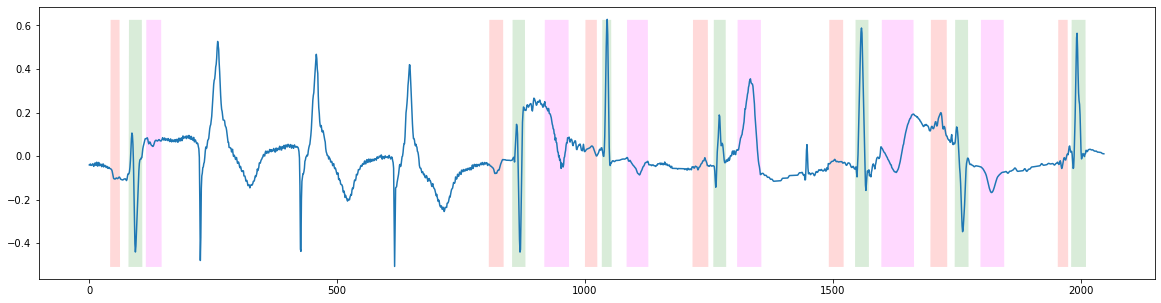

In [27]:
N = 2048

beats = []
ids = []

# Include first beat
ids.append(('TPsignal',np.random.randint(0,len(TPsignal))))
beats.append(utils.signal.on_off_correction(TPsignal[list(TPsignal)[ids[-1][1]]]))
# beats.append(TPsignal[list(TPsignal)[np.random.randint(0,len(TPsignal))]])
size = beats[0].size
masks = np.zeros((size,))
onset = np.random.randint(0,size)
while size-onset < N:
    # P wave (sometimes)
    if np.random.rand(1) < 0.75:
        # p = utils.signal.on_off_correction(Psignal[list(Psignal)[np.random.randint(0,len(Psignal))]])
        ids.append(('Psignal',np.random.randint(0,len(Psignal))))
        p = trailonset(Psignal[list(Psignal)[ids[-1][1]]],beats[-1][-1])
        # p = Psignal[list(Psignal)[np.random.randint(0,len(Psignal))]]
        beats.append(p)
        masks = np.concatenate((masks,1*np.ones((p.size,))))

    # PQ segment
    # pq = utils.signal.on_off_correction(PQsignal[list(PQsignal)[np.random.randint(0,len(PQsignal))]])
    ids.append(('PQsignal',np.random.randint(0,len(PQsignal))))
    pq = trailonset(PQsignal[list(PQsignal)[ids[-1][1]]],beats[-1][-1])
    # pq = PQsignal[list(PQsignal)[np.random.randint(0,len(PQsignal))]]
    beats.append(pq)
    masks = np.concatenate((masks,np.zeros((pq.size,))))

    # QRS wave
    # qrs = utils.signal.on_off_correction(QRSsignal[list(QRSsignal)[np.random.randint(0,len(QRSsignal))]])
    ids.append(('QRSsignal',np.random.randint(0,len(QRSsignal))))
    qrs = trailonset(QRSsignal[list(QRSsignal)[ids[-1][1]]],beats[-1][-1])
    # qrs = QRSsignal[list(QRSsignal)[np.random.randint(0,len(QRSsignal))]]
    beats.append(qrs)
    masks = np.concatenate((masks,2*np.ones((qrs.size,))))

    # ST segment
    # st = utils.signal.on_off_correction(STsignal[list(STsignal)[np.random.randint(0,len(STsignal))]])
    ids.append(('STsignal',np.random.randint(0,len(STsignal))))
    st = trailonset(STsignal[list(STsignal)[ids[-1][1]]],beats[-1][-1])
    # st = STsignal[list(STsignal)[np.random.randint(0,len(STsignal))]]
    beats.append(st)
    masks = np.concatenate((masks,np.zeros((st.size,))))

    # T wave
    # t = utils.signal.on_off_correction(Tsignal[list(Tsignal)[np.random.randint(0,len(Tsignal))]])
    ids.append(('Tsignal',np.random.randint(0,len(Tsignal))))
    t = trailonset(Tsignal[list(Tsignal)[ids[-1][1]]],beats[-1][-1])
    # t = Tsignal[list(Tsignal)[np.random.randint(0,len(Tsignal))]]
    beats.append(t)
    masks = np.concatenate((masks,3*np.ones((t.size,))))

    # TP segment
    # tp = utils.signal.on_off_correction(TPsignal[list(TPsignal)[np.random.randint(0,len(TPsignal))]])
    ids.append(('TPsignal',np.random.randint(0,len(TPsignal))))
    tp = trailonset(TPsignal[list(TPsignal)[ids[-1][1]]],beats[-1][-1])
    # tp = TPsignal[list(TPsignal)[np.random.randint(0,len(TPsignal))]]
    beats.append(tp)
    masks = np.concatenate((masks,np.zeros((tp.size,))))

    size = sum([beats[i].size for i in range(len(beats))])

w = 51
sig = np.concatenate(beats)[onset:onset+2048]
sig = sp.signal.filtfilt(*sp.signal.butter(4,   0.5/250, 'high'),sig)
signal = sig# + np.convolve(np.cumsum(norm.rvs(scale=0.15**(2*0.5),size=N)),np.hamming(w)/(w/2),mode='same')

masks = masks[onset:onset+2048]
masks_all = np.zeros((N,3),dtype=bool)
masks_all[:,0] = masks == 1
masks_all[:,1] = masks == 2
masks_all[:,2] = masks == 3
mskplt = ((np.max(signal)-np.min(signal))*masks_all)+np.min(signal)

plt.figure(figsize=(20,5))
plt.plot(signal)
plt.gca().fill_between(np.arange(N), mskplt[:,0], mskplt[:,0].min(), linewidth=0, alpha=0.15, color='red')
plt.gca().fill_between(np.arange(N), mskplt[:,1], mskplt[:,1].min(), linewidth=0, alpha=0.15, color='green')
plt.gca().fill_between(np.arange(N), mskplt[:,2], mskplt[:,2].min(), linewidth=0, alpha=0.15, color='magenta')
plt.show()

In [28]:
ids

[('TPsignal', 45986),
 ('Psignal', 26040),
 ('PQsignal', 5049),
 ('QRSsignal', 3525),
 ('STsignal', 9882),
 ('Tsignal', 13439),
 ('TPsignal', 46000),
 ('Psignal', 30490),
 ('PQsignal', 7884),
 ('QRSsignal', 26577),
 ('STsignal', 14999),
 ('Tsignal', 51721),
 ('TPsignal', 47198),
 ('Psignal', 5451),
 ('PQsignal', 20688),
 ('QRSsignal', 7320),
 ('STsignal', 2113),
 ('Tsignal', 36628),
 ('TPsignal', 25836),
 ('Psignal', 43297),
 ('PQsignal', 31807),
 ('QRSsignal', 16897),
 ('STsignal', 19885),
 ('Tsignal', 25945),
 ('TPsignal', 30453),
 ('Psignal', 9742),
 ('PQsignal', 32879),
 ('QRSsignal', 26684),
 ('STsignal', 20061),
 ('Tsignal', 46142),
 ('TPsignal', 52299),
 ('Psignal', 14646),
 ('PQsignal', 18569),
 ('QRSsignal', 30978),
 ('STsignal', 1244),
 ('Tsignal', 28178),
 ('TPsignal', 37351),
 ('Psignal', 38804),
 ('PQsignal', 23696),
 ('QRSsignal', 15040),
 ('STsignal', 9578),
 ('Tsignal', 23075),
 ('TPsignal', 41601)]

-sel104_1_161


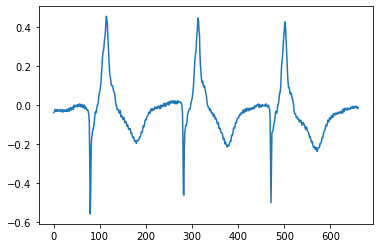

In [29]:
i = 46000
f = TPsignal
print(list(f)[i])
plt.plot(f[list(f)[i]])

# fiducials to delete

* QRS - 111_AVF_24
* QRS - sel820_1_156
* QRS - 95_AVR_16
* ~TP - sel306_1_211~
* ~TP - sel114_0_179~
* PT - sel803_0_109